Neural Networks with Python

In [18]:
import pandas as pd
import numpy as np

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import TimeDistributed, GlobalAveragePooling1D, Activation, Input, LSTM, GRU, Dense, Dropout, Flatten, Embedding, SpatialDropout1D, Bidirectional, CuDNNGRU
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, concatenate
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, CSVLogger

import tensorflow as tf
from tensorflow import set_random_seed
from keras import backend as K

# This part required only for GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config=config)
K.set_session(sess)

seed = 10293239

from tensorflow import keras
from tensorflow.keras import layers

from math import sqrt

In [5]:
bugs = pd.read_csv('bugs.csv', sep=';', index_col=None)
bugs.head(4)

,CBO,DIT,FanIn,FanOut,LCOM,NOC,RFC,WMC,LOC,Attributes,AttributesInherited,Methods,MethodsInherited,Bugs
0,9,2,1,9,15,0,34,20,122,1,8,6,19,0
1,1,1,1,0,0,0,1,1,4,2,0,1,8,0
2,114,1,102,18,190,6,156,176,484,131,249,20,8,1
3,5,6,1,4,10,0,18,12,33,0,61,5,207,0


In [4]:
# we will make a copy of the main data
bugs_small = bugs[["CBO", "DIT", "FanOut ", "LCOM", "NOC", "LOC", "Attributes ", "AttributesInherited ", "MethodsInherited ", "Bugs "]]
bugs_small

,CBO,DIT,FanOut,LCOM,NOC,LOC,Attributes,AttributesInherited,MethodsInherited,Bugs
0,9,2,9,15,0,122,1,8,19,0
1,1,1,0,0,0,4,2,0,8,0
2,114,1,18,190,6,484,131,249,8,1
3,5,6,4,10,0,33,0,61,207,0
4,23,2,22,820,0,673,7,416,8,0
...,...,...,...,...,...,...,...,...,...,...
992,0,1,0,1,2,3,3,0,8,0
993,9,6,7,15,1,48,3,386,95,0
994,35,3,10,153,9,306,11,52,27,1
995,7,2,7,190,0,87,2,6,30,0


In [6]:
bugs_small.isna().sum()

CBO                     0
DIT                     0
FanOut                  0
LCOM                    0
NOC                     0
LOC                     0
Attributes              0
AttributesInherited     0
MethodsInherited        0
Bugs                    0
dtype: int64

In [7]:
y = bugs_small['Bugs ']
X = bugs_small.drop(['Bugs '], axis=1, inplace=False)

In [8]:
def get_regression_model(n_features=None):
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[n_features]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [9]:
#For regression
np.random.seed(seed)
set_random_seed(seed)

callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=10)
]

pipeline = []
pipeline.append(('standard', StandardScaler()))

In [10]:
#For regression
EPOCHS = 1000
pipeline.append(('regressor', KerasRegressor(build_fn=get_regression_model,  
                                        epochs=EPOCHS,
                                        batch_size=128, 
                                        verbose=2, 
                                        callbacks=callbacks_list,
                                        n_features=X.shape[1]))) 

In [11]:
model = Pipeline(pipeline)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=seed, stratify=y)

In [13]:
model.fit(X_train, y_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 667 samples
Epoch 1/1000
667/667 - 1s - loss: 1.1850 - mean_absolute_error: 0.4915 - mean_squared_error: 1.1850
Epoch 2/1000
667/667 - 0s - loss: 0.8464 - mean_absolute_error: 0.4407 - mean_squared_error: 0.8464
Epoch 3/1000
667/667 - 0s - loss: 0.7481 - mean_absolute_error: 0.4299 - mean_squared_error: 0.7481
Epoch 4/1000
667/667 - 0s - loss: 0.7048 - mean_absolute_error: 0.4052 - mean_squared_error: 0.7048
Epoch 5/1000
667/667 - 0s - loss: 0.6858 - mean_absolute_error: 0.4046 - mean_squared_error: 0.6858
Epoch 6/1000
667/667 - 0s - loss: 0.6684 - mean_absolute_error: 0.3856 - mean_squared_error: 0.6684
Epoch 7/1000
667/667 - 0s - loss: 0.6650 - mean_absolute_error: 0.3864 - mean_squared_error: 0.6650
Epoch 8/1000
667/667 - 0s - loss: 0.6505 - mean_absolute_error: 0.3872 - mean_squared_error: 0.6505
Epoch 9/1000
667/667 - 0s - loss: 0.6534 - mean_absolute_error: 0.3915 - mean_squared_error: 0.653

D:\ProgramFiles\Anaconda\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 21/1000
667/667 - 0s - loss: 0.5460 - mean_absolute_error: 0.3871 - mean_squared_error: 0.5460
Epoch 22/1000
667/667 - 0s - loss: 0.5453 - mean_absolute_error: 0.3641 - mean_squared_error: 0.5453
Epoch 23/1000
667/667 - 0s - loss: 0.5482 - mean_absolute_error: 0.3731 - mean_squared_error: 0.5482
Epoch 24/1000
667/667 - 0s - loss: 0.5328 - mean_absolute_error: 0.3724 - mean_squared_error: 0.5328
Epoch 25/1000
667/667 - 0s - loss: 0.5520 - mean_absolute_error: 0.3691 - mean_squared_error: 0.5520
Epoch 26/1000
667/667 - 0s - loss: 0.5254 - mean_absolute_error: 0.3671 - mean_squared_error: 0.5254
Epoch 27/1000
667/667 - 0s - loss: 0.5197 - mean_absolute_error: 0.3725 - mean_squared_error: 0.5197
Epoch 28/1000
667/667 - 0s - loss: 0.5254 - mean_absolute_error: 0.3709 - mean_squared_error: 0.5254
Epoch 29/1000
667/667 - 0s - loss: 0.5139 - mean_absolute_error: 0.3619 - mean_squared_error: 0.5139
Epoch 30/1000
667/667 - 0s - loss: 0.5033 - mean_absolute_error: 0.3681 - mean_squared_erro

Epoch 103/1000
667/667 - 0s - loss: 0.2848 - mean_absolute_error: 0.2952 - mean_squared_error: 0.2848
Epoch 104/1000
667/667 - 0s - loss: 0.2827 - mean_absolute_error: 0.2914 - mean_squared_error: 0.2827
Epoch 105/1000
667/667 - 0s - loss: 0.2954 - mean_absolute_error: 0.3124 - mean_squared_error: 0.2954
Epoch 106/1000
667/667 - 0s - loss: 0.2696 - mean_absolute_error: 0.2840 - mean_squared_error: 0.2696
Epoch 107/1000
667/667 - 0s - loss: 0.2936 - mean_absolute_error: 0.3161 - mean_squared_error: 0.2936
Epoch 108/1000
667/667 - 0s - loss: 0.2750 - mean_absolute_error: 0.2933 - mean_squared_error: 0.2750
Epoch 109/1000
667/667 - 0s - loss: 0.2684 - mean_absolute_error: 0.2903 - mean_squared_error: 0.2684
Epoch 110/1000
667/667 - 0s - loss: 0.2758 - mean_absolute_error: 0.3014 - mean_squared_error: 0.2758
Epoch 111/1000
667/667 - 0s - loss: 0.2714 - mean_absolute_error: 0.2935 - mean_squared_error: 0.2714
Epoch 112/1000
667/667 - 0s - loss: 0.2767 - mean_absolute_error: 0.2937 - mean_sq

Epoch 184/1000
667/667 - 0s - loss: 0.1697 - mean_absolute_error: 0.2417 - mean_squared_error: 0.1697
Epoch 185/1000
667/667 - 0s - loss: 0.1818 - mean_absolute_error: 0.2460 - mean_squared_error: 0.1818
Epoch 186/1000
667/667 - 0s - loss: 0.1691 - mean_absolute_error: 0.2423 - mean_squared_error: 0.1691
Epoch 187/1000
667/667 - 0s - loss: 0.1798 - mean_absolute_error: 0.2554 - mean_squared_error: 0.1798
Epoch 188/1000
667/667 - 0s - loss: 0.1702 - mean_absolute_error: 0.2482 - mean_squared_error: 0.1702
Epoch 189/1000
667/667 - 0s - loss: 0.1775 - mean_absolute_error: 0.2467 - mean_squared_error: 0.1775
Epoch 190/1000
667/667 - 0s - loss: 0.1920 - mean_absolute_error: 0.2562 - mean_squared_error: 0.1920
Epoch 191/1000
667/667 - 0s - loss: 0.1640 - mean_absolute_error: 0.2330 - mean_squared_error: 0.1640
Epoch 192/1000
667/667 - 0s - loss: 0.1835 - mean_absolute_error: 0.2737 - mean_squared_error: 0.1835
Epoch 193/1000
667/667 - 0s - loss: 0.1675 - mean_absolute_error: 0.2431 - mean_sq

Epoch 265/1000
667/667 - 0s - loss: 0.1307 - mean_absolute_error: 0.2235 - mean_squared_error: 0.1307
Epoch 266/1000
667/667 - 0s - loss: 0.1452 - mean_absolute_error: 0.2393 - mean_squared_error: 0.1452
Epoch 267/1000
667/667 - 0s - loss: 0.1223 - mean_absolute_error: 0.2153 - mean_squared_error: 0.1223
Epoch 268/1000
667/667 - 0s - loss: 0.1281 - mean_absolute_error: 0.2222 - mean_squared_error: 0.1281
Epoch 269/1000
667/667 - 0s - loss: 0.1288 - mean_absolute_error: 0.2211 - mean_squared_error: 0.1288
Epoch 270/1000
667/667 - 0s - loss: 0.1159 - mean_absolute_error: 0.2049 - mean_squared_error: 0.1159
Epoch 271/1000
667/667 - 0s - loss: 0.1382 - mean_absolute_error: 0.2436 - mean_squared_error: 0.1382
Epoch 272/1000
667/667 - 0s - loss: 0.1124 - mean_absolute_error: 0.2016 - mean_squared_error: 0.1124
Epoch 273/1000
667/667 - 0s - loss: 0.1381 - mean_absolute_error: 0.2351 - mean_squared_error: 0.1381
Epoch 274/1000
667/667 - 0s - loss: 0.1266 - mean_absolute_error: 0.2243 - mean_sq

Epoch 346/1000
667/667 - 0s - loss: 0.0979 - mean_absolute_error: 0.1992 - mean_squared_error: 0.0979
Epoch 347/1000
667/667 - 0s - loss: 0.0899 - mean_absolute_error: 0.1819 - mean_squared_error: 0.0899
Epoch 348/1000
667/667 - 0s - loss: 0.0942 - mean_absolute_error: 0.1913 - mean_squared_error: 0.0942
Epoch 349/1000
667/667 - 0s - loss: 0.0915 - mean_absolute_error: 0.1929 - mean_squared_error: 0.0915
Epoch 350/1000
667/667 - 0s - loss: 0.1235 - mean_absolute_error: 0.2221 - mean_squared_error: 0.1235
Epoch 351/1000
667/667 - 0s - loss: 0.0957 - mean_absolute_error: 0.1935 - mean_squared_error: 0.0957
Epoch 352/1000
667/667 - 0s - loss: 0.0938 - mean_absolute_error: 0.1957 - mean_squared_error: 0.0938
Epoch 353/1000
667/667 - 0s - loss: 0.1039 - mean_absolute_error: 0.2023 - mean_squared_error: 0.1039
Epoch 354/1000
667/667 - 0s - loss: 0.1060 - mean_absolute_error: 0.2001 - mean_squared_error: 0.1060
Epoch 355/1000
667/667 - 0s - loss: 0.1047 - mean_absolute_error: 0.2064 - mean_sq

Epoch 427/1000
667/667 - 0s - loss: 0.0966 - mean_absolute_error: 0.2077 - mean_squared_error: 0.0966
Epoch 428/1000
667/667 - 0s - loss: 0.1378 - mean_absolute_error: 0.2039 - mean_squared_error: 0.1378
Epoch 429/1000
667/667 - 0s - loss: 0.0717 - mean_absolute_error: 0.1665 - mean_squared_error: 0.0717
Epoch 430/1000
667/667 - 0s - loss: 0.0786 - mean_absolute_error: 0.1810 - mean_squared_error: 0.0786
Epoch 431/1000
667/667 - 0s - loss: 0.0736 - mean_absolute_error: 0.1759 - mean_squared_error: 0.0736
Epoch 432/1000
667/667 - 0s - loss: 0.0828 - mean_absolute_error: 0.1878 - mean_squared_error: 0.0828
Epoch 433/1000
667/667 - 0s - loss: 0.0838 - mean_absolute_error: 0.1867 - mean_squared_error: 0.0838
Epoch 434/1000
667/667 - 0s - loss: 0.0859 - mean_absolute_error: 0.1920 - mean_squared_error: 0.0859
Epoch 435/1000
667/667 - 0s - loss: 0.0744 - mean_absolute_error: 0.1702 - mean_squared_error: 0.0744
Epoch 436/1000
667/667 - 0s - loss: 0.0873 - mean_absolute_error: 0.1996 - mean_sq

Epoch 508/1000
667/667 - 0s - loss: 0.0632 - mean_absolute_error: 0.1568 - mean_squared_error: 0.0632
Epoch 509/1000
667/667 - 0s - loss: 0.1137 - mean_absolute_error: 0.1920 - mean_squared_error: 0.1137
Epoch 510/1000
667/667 - 0s - loss: 0.0642 - mean_absolute_error: 0.1615 - mean_squared_error: 0.0642
Epoch 511/1000
667/667 - 0s - loss: 0.0692 - mean_absolute_error: 0.1722 - mean_squared_error: 0.0692
Epoch 512/1000
667/667 - 0s - loss: 0.0593 - mean_absolute_error: 0.1482 - mean_squared_error: 0.0593
Epoch 513/1000
667/667 - 0s - loss: 0.0785 - mean_absolute_error: 0.1879 - mean_squared_error: 0.0785
Epoch 514/1000
667/667 - 0s - loss: 0.0689 - mean_absolute_error: 0.1675 - mean_squared_error: 0.0689
Epoch 515/1000
667/667 - 0s - loss: 0.0809 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0809
Epoch 516/1000
667/667 - 0s - loss: 0.0993 - mean_absolute_error: 0.1895 - mean_squared_error: 0.0993
Epoch 517/1000
667/667 - 0s - loss: 0.0677 - mean_absolute_error: 0.1660 - mean_sq

Epoch 589/1000
667/667 - 0s - loss: 0.0795 - mean_absolute_error: 0.1825 - mean_squared_error: 0.0795
Epoch 590/1000
667/667 - 0s - loss: 0.0575 - mean_absolute_error: 0.1564 - mean_squared_error: 0.0575
Epoch 591/1000
667/667 - 0s - loss: 0.0597 - mean_absolute_error: 0.1538 - mean_squared_error: 0.0597
Epoch 592/1000
667/667 - 0s - loss: 0.0538 - mean_absolute_error: 0.1412 - mean_squared_error: 0.0538
Epoch 593/1000
667/667 - 0s - loss: 0.0725 - mean_absolute_error: 0.1751 - mean_squared_error: 0.0725
Epoch 594/1000
667/667 - 0s - loss: 0.0724 - mean_absolute_error: 0.1781 - mean_squared_error: 0.0724
Epoch 595/1000
667/667 - 0s - loss: 0.0597 - mean_absolute_error: 0.1581 - mean_squared_error: 0.0597
Epoch 596/1000
667/667 - 0s - loss: 0.0561 - mean_absolute_error: 0.1520 - mean_squared_error: 0.0561
Epoch 597/1000
667/667 - 0s - loss: 0.0721 - mean_absolute_error: 0.1824 - mean_squared_error: 0.0721
Epoch 598/1000
667/667 - 0s - loss: 0.0640 - mean_absolute_error: 0.1616 - mean_sq

Epoch 670/1000
667/667 - 0s - loss: 0.0521 - mean_absolute_error: 0.1425 - mean_squared_error: 0.0521
Epoch 671/1000
667/667 - 0s - loss: 0.0738 - mean_absolute_error: 0.1883 - mean_squared_error: 0.0738
Epoch 672/1000
667/667 - 0s - loss: 0.0571 - mean_absolute_error: 0.1543 - mean_squared_error: 0.0571
Epoch 673/1000
667/667 - 0s - loss: 0.0486 - mean_absolute_error: 0.1350 - mean_squared_error: 0.0486
Epoch 674/1000
667/667 - 0s - loss: 0.0498 - mean_absolute_error: 0.1409 - mean_squared_error: 0.0498
Epoch 675/1000
667/667 - 0s - loss: 0.0666 - mean_absolute_error: 0.1715 - mean_squared_error: 0.0666
Epoch 676/1000
667/667 - 0s - loss: 0.0634 - mean_absolute_error: 0.1763 - mean_squared_error: 0.0634
Epoch 677/1000
667/667 - 0s - loss: 0.0649 - mean_absolute_error: 0.1678 - mean_squared_error: 0.0649
Epoch 678/1000
667/667 - 0s - loss: 0.0593 - mean_absolute_error: 0.1461 - mean_squared_error: 0.0593
Epoch 679/1000
667/667 - 0s - loss: 0.0687 - mean_absolute_error: 0.1740 - mean_sq

Epoch 751/1000
667/667 - 0s - loss: 0.0699 - mean_absolute_error: 0.1683 - mean_squared_error: 0.0699
Epoch 752/1000
667/667 - 0s - loss: 0.0516 - mean_absolute_error: 0.1511 - mean_squared_error: 0.0516
Epoch 753/1000
667/667 - 0s - loss: 0.0531 - mean_absolute_error: 0.1506 - mean_squared_error: 0.0531
Epoch 754/1000
667/667 - 0s - loss: 0.0603 - mean_absolute_error: 0.1584 - mean_squared_error: 0.0603
Epoch 755/1000
667/667 - 0s - loss: 0.0497 - mean_absolute_error: 0.1427 - mean_squared_error: 0.0497
Epoch 756/1000
667/667 - 0s - loss: 0.0726 - mean_absolute_error: 0.1860 - mean_squared_error: 0.0726
Epoch 757/1000
667/667 - 0s - loss: 0.0478 - mean_absolute_error: 0.1371 - mean_squared_error: 0.0478
Epoch 758/1000
667/667 - 0s - loss: 0.0580 - mean_absolute_error: 0.1523 - mean_squared_error: 0.0580
Epoch 759/1000
667/667 - 0s - loss: 0.0870 - mean_absolute_error: 0.1900 - mean_squared_error: 0.0870
Epoch 760/1000
667/667 - 0s - loss: 0.0425 - mean_absolute_error: 0.1312 - mean_sq

Epoch 832/1000
667/667 - 0s - loss: 0.0495 - mean_absolute_error: 0.1418 - mean_squared_error: 0.0495
Epoch 833/1000
667/667 - 0s - loss: 0.0567 - mean_absolute_error: 0.1465 - mean_squared_error: 0.0567
Epoch 834/1000
667/667 - 0s - loss: 0.0593 - mean_absolute_error: 0.1598 - mean_squared_error: 0.0593
Epoch 835/1000
667/667 - 0s - loss: 0.0427 - mean_absolute_error: 0.1258 - mean_squared_error: 0.0427
Epoch 836/1000
667/667 - 0s - loss: 0.0534 - mean_absolute_error: 0.1567 - mean_squared_error: 0.0534
Epoch 837/1000
667/667 - 0s - loss: 0.0656 - mean_absolute_error: 0.1597 - mean_squared_error: 0.0656
Epoch 838/1000
667/667 - 0s - loss: 0.0417 - mean_absolute_error: 0.1245 - mean_squared_error: 0.0417
Epoch 839/1000
667/667 - 0s - loss: 0.0493 - mean_absolute_error: 0.1327 - mean_squared_error: 0.0493
Epoch 840/1000
667/667 - 0s - loss: 0.0575 - mean_absolute_error: 0.1658 - mean_squared_error: 0.0575
Epoch 841/1000
667/667 - 0s - loss: 0.0457 - mean_absolute_error: 0.1333 - mean_sq

Epoch 913/1000
667/667 - 0s - loss: 0.0638 - mean_absolute_error: 0.1823 - mean_squared_error: 0.0638
Epoch 914/1000
667/667 - 0s - loss: 0.0446 - mean_absolute_error: 0.1341 - mean_squared_error: 0.0446
Epoch 915/1000
667/667 - 0s - loss: 0.0446 - mean_absolute_error: 0.1335 - mean_squared_error: 0.0446
Epoch 916/1000
667/667 - 0s - loss: 0.0523 - mean_absolute_error: 0.1616 - mean_squared_error: 0.0523
Epoch 917/1000
667/667 - 0s - loss: 0.0440 - mean_absolute_error: 0.1415 - mean_squared_error: 0.0440
Epoch 918/1000
667/667 - 0s - loss: 0.0366 - mean_absolute_error: 0.1126 - mean_squared_error: 0.0366
Epoch 919/1000
667/667 - 0s - loss: 0.0790 - mean_absolute_error: 0.1877 - mean_squared_error: 0.0790
Epoch 920/1000
667/667 - 0s - loss: 0.0459 - mean_absolute_error: 0.1353 - mean_squared_error: 0.0459
Epoch 921/1000
667/667 - 0s - loss: 0.0441 - mean_absolute_error: 0.1352 - mean_squared_error: 0.0441
Epoch 922/1000
667/667 - 0s - loss: 0.0627 - mean_absolute_error: 0.1765 - mean_sq

Epoch 994/1000
667/667 - 0s - loss: 0.0460 - mean_absolute_error: 0.1436 - mean_squared_error: 0.0460
Epoch 995/1000
667/667 - 0s - loss: 0.0494 - mean_absolute_error: 0.1507 - mean_squared_error: 0.0494
Epoch 996/1000
667/667 - 0s - loss: 0.0460 - mean_absolute_error: 0.1458 - mean_squared_error: 0.0460
Epoch 997/1000
667/667 - 0s - loss: 0.0514 - mean_absolute_error: 0.1552 - mean_squared_error: 0.0514
Epoch 998/1000
667/667 - 0s - loss: 0.0405 - mean_absolute_error: 0.1213 - mean_squared_error: 0.0405
Epoch 999/1000
667/667 - 0s - loss: 0.0525 - mean_absolute_error: 0.1532 - mean_squared_error: 0.0525
Epoch 1000/1000
667/667 - 0s - loss: 0.0392 - mean_absolute_error: 0.1228 - mean_squared_error: 0.0392


Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regressor',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002B488A215C8>)],
         verbose=False)

In [15]:
example_batch = X_train[:100]
example_result = model.predict(example_batch)
example_result

100/100 - 0s


array([-7.45830387e-02, -5.39985709e-02, -1.51957348e-01,  6.99390844e-03,
       -1.89502880e-01, -7.41376728e-02,  2.99368709e-01,  5.38112596e-03,
       -9.51096267e-02,  1.81351975e-01, -7.52416402e-02, -2.32159309e-02,
        3.98685956e+00,  4.70192917e-02,  2.07833982e+00,  8.77536714e-01,
       -2.02288806e-01,  9.88375366e-01, -4.14875261e-02, -5.15021496e-02,
       -9.95924026e-02,  1.16409019e-01,  4.38956209e-02,  6.74042255e-02,
       -2.32657716e-01,  5.47839582e-01, -2.95089297e-02, -1.79637536e-01,
        1.09343715e-02,  6.01242924e+00, -7.31610358e-02, -2.57785730e-02,
       -3.36764380e-03, -1.61268130e-01,  2.06900127e-02,  2.68725562e+00,
        2.06266880e+00,  9.90623832e-01,  1.76357813e-02,  3.72532792e-02,
        2.64164992e-02, -2.46888354e-01,  2.09993982e+00,  7.22111613e-02,
        8.13791752e-01, -1.89294025e-01,  1.79987267e-01, -1.97096333e-01,
       -4.84280996e-02, -1.29854195e-02, -5.78107648e-02, -8.14743787e-02,
        7.64876157e-02,  

In [16]:
y_pred = model.predict(X_test)

330/330 - 0s


In [19]:
#For regression
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

variance = explained_variance_score(y_test, y_pred)
max_error = max_error(y_test, y_pred)
mean_absolute_error = mean_absolute_error(y_test, y_pred)
mean_squared_error = mean_squared_error(y_test, y_pred)
#mean_squared_log_error = mean_squared_log_error(y_test, y_pred)
median_absolute_error = median_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

"Variance = {:.3f}, Max Error = {:.3f}, Mean Absolute Error = {:.3f}, Mean Squared Error = {:.3f}, Median Absolute Error = {:.3f}, R2 = {:.3f}, RMSE = {:.3f}".format(variance, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, sqrt(mean_squared_error))

'Variance = 0.147, Max Error = 10.018, Mean Absolute Error = 0.427, Mean Squared Error = 0.966, Median Absolute Error = 0.182, R2 = 0.142, RMSE = 0.983'

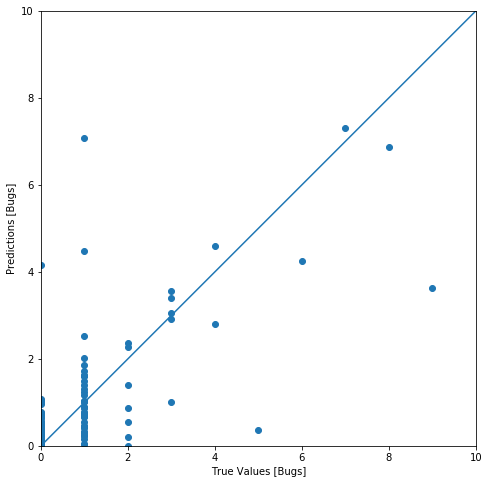

In [14]:
#For regression
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [Bugs]')
plt.ylabel('Predictions [Bugs]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

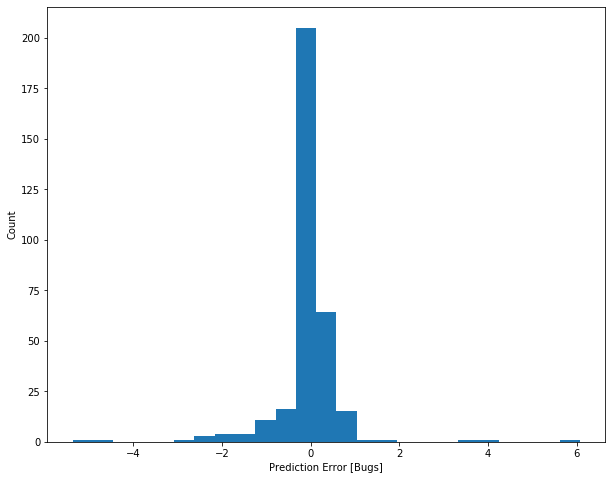

In [15]:
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Bugs]")
_ = plt.ylabel("Count")